## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [ ]:
!python -m pip install tensorboard timm

In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# # check whether run in Colab
# if 'google.colab' in sys.modules:
#     print('Running in Colab.')
#     !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
#     !git clone https://github.com/facebookresearch/mae.git
#     sys.path.append('./mae')
# else:
#     sys.path.append('..')
import models_mae

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define utils

In [122]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cuda')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    model.to('cuda')
    return model


@torch.no_grad()
def run_one_image(img, model, ratio, img_name):
    device = next(model.parameters()).device
    x = torch.tensor(img).to(device)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    print("forward starts")
    loss, y, mask = model(x.float(), mask_ratio=ratio)
    print("forward ends")
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach() # .cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach() # .cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask
    
    x = x.detach().cpu()
    im_masked = im_masked.detach().cpu()
    y = y.detach().cpu()
    im_paste = im_paste.detach().cpu()

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")
    
    # Save im_paste[0] as a PIL image by using the naming of model+ratio+name of img
    # im_paste_img = torch.clip((im_paste[0] * imagenet_std + imagenet_mean) * 255, 0, 255).int()
    # im_paste_img = Image.fromarray(im_paste_img.numpy().astype(np.uint8))
    # im_paste_img.save(f"reconstructed_img/{model.__class__.__name__}_{ratio}_{img_name}")
    plt.show()

### Load an image

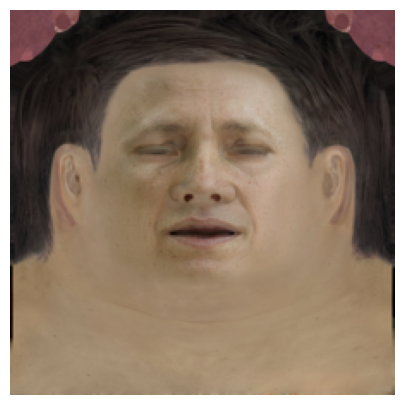

In [117]:
# load an image
# img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
# img = Image.open(requests.get(img_url, stream=True).raw)
# img = Image.open('/root/mae/img_data/train/faces/000000.png')
img = Image.open('002000.png')
img_name = '002000.png'
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [123]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
#!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = "/root/mae/mae_visualize_vit_large/checkpoint-49.pth"
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:
forward starts
forward ends


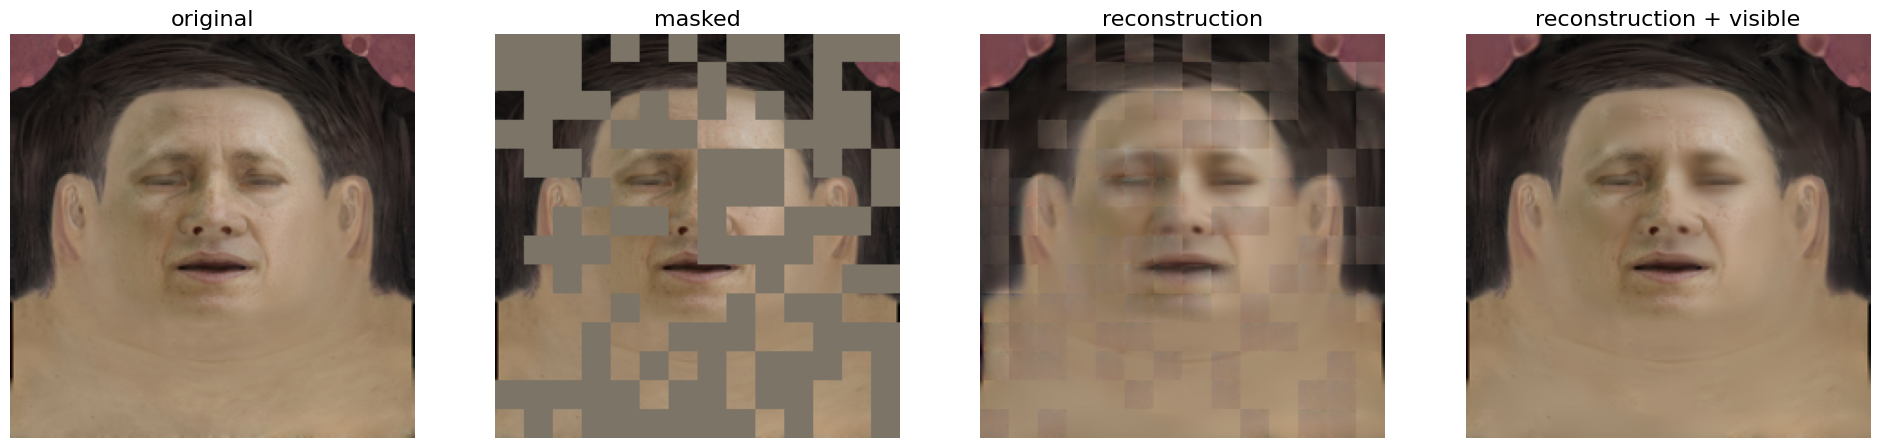

In [126]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(1337)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae, 0.5, img_name)

### Load another pre-trained MAE model

In [9]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
# !wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

# chkpt_dir = 'mae_visualize_vit_large.pth'
chkpt_dir = "/root/mae/mae_w_gan_loss/checkpoint-49.pth"
model_mae_gan = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with extra GAN loss:
forward starts
forward ends


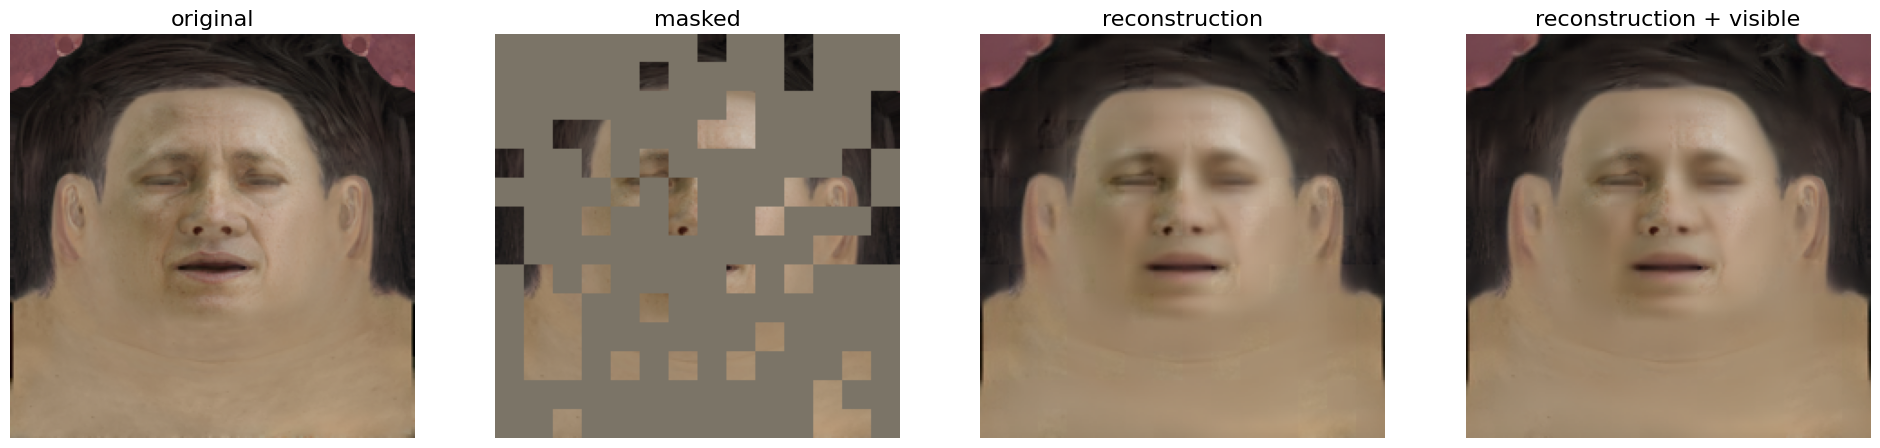

In [79]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(1337)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan, 0.75, img_name)

In [52]:
model_mae

MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0-23): 24 x Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
  (decoder_embed): Linear(in_features=1024, out_features=